# Bayesian Optimisation: 1D test functions, Gaussian derived likelihoods and custom deterministic kernel

* This notebook provides a basic toolbox for the Bayesian optimisation using Gaussian processess framework as implemented in the pyro.contrib.gp module.
* The test functions used in the optimisation are 1D.
* The supported kernel is RBF.
* The supported acquisition function is a lower confidence bound.
* The tested `pyro.contrib.gp.models` are GPRegressor and VariationalGP. VariationalGP is tested with custom implementation of Gaussian likelihood.
* The censored data for the "wrong model" is supported: benchmark and Bayessian optimisation.



## Initiate the Notebook

In [1]:
!pip install -q pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 3.5 MB/s eta 0:00:00


In [2]:
import os

import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to
from torch.nn import Parameter
from torch import nn

import numpy as np
import tqdm

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# Data Generation



### Code

In [3]:
 def plot_data(noisy=False, censored=False, benchmark=False):
  # plots extended interval used for testing and investigating extrapolation
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  # plots the domain from which
  plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])

  # the randomly sampled set to test the efficiency of Bayes Opt
  if benchmark==True:
    plt.scatter(X_train_benchmark, y_train_benchmark, label="observations - benchmark set",  alpha=0.85, color=sns.color_palette()[0], marker='*')
    if noisy==True:
      plt.scatter(X_train_benchmark, y_train_benchmark_noisy, label="noisy observations - benchmark set", s=25, alpha=0.55, color=sns.color_palette()[1], marker='*')
    if censored==True:
      plt.scatter(X_train_benchmark, y_train_benchmark_censored, label="observations censored - benchmark set", s=25, color=sns.color_palette()[2], marker='P')

  # plots the points used for initiating the Bayes optimiser
  plt.scatter(X_train, y_train, label="observations - initiate Bayes Opt",  alpha=0.65, color=sns.color_palette()[3])
  # perturbed observation
  if noisy==True:
    plt.scatter(X_train, y_train_noisy, label="noisy observations - initiate Bayes Opt", s=16, alpha=0.85, color=sns.color_palette()[1])
   # censored observation
  if censored==True:
    plt.scatter(X_train, y_train_censored, label="observations censored - initiate Bayes Opt", s=16, color=sns.color_palette()[4], marker='x')


  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title("True generative process")

### 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  

In [4]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)
fcn4 = lambda x: 0.5 * torch.sin(x) - 0.02 * torch.pow((10 - x), 2) + 2


fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 200, 1], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 300, 0.2], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 5000, 2], fcn3],
    'fcn4': ["$f(x) = 0.5 \sin(x) - 0.02(10 - x)^2 + 2$", [0, 20, 1000, 5000, 5], fcn4]
    }

In [5]:
# set hyperparameters for data generation

fcn_key_ = 'fcn2' # select function
noise_std = 0.2 # add noise

N = 4 # number of training data points
N_benchmark = 30 # the total budget of the points available for the fitting

# set perscentile corresponding to the treshold --> values smaller than given treshold are assigned treshold value
# if set to 0, no censoring is applied
treshold = 20

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for initiating the Bayesian optimisation
* (X_train, y_train_noisy) is uniformly subsampled N points used for initiating the Bayesian optimisation with mixed in Gaussian noise with variance specified
in variable noise_std, i.e. corresponds to the perturbed initial data
* (X_train_benchmark, y_train_benchmark_noisy) is uniformly subsampled N_benchmark points used for benchamriking the Bayesian optimiser against the uniformly randomly sampled points with N_benchmark - N corresponding to the number of steps in Bayes optimisation
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test

In [6]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set for initiating the Bayesion optimisation
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))
# mix in normal noise
y_train_noisy = y_train + dist.Normal(0.0, noise_std).sample(sample_shape=(N,))

# sample training set for initiating the Bayesion optimisation
X_train_benchmark = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N_benchmark,))
y_train_benchmark = fcn_dict[fcn_key_][2](torch.Tensor(X_train_benchmark))
# mix in normal noise
y_train_benchmark_noisy = y_train_benchmark + dist.Normal(0.0, noise_std).sample(sample_shape=(N_benchmark,))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

### Censoring
* compute bound for a given percentile and replaces all values smaller than the bound with the bound value
* `censoring_id` is an identifier indicating positions of the values on which the censoring was applied  

In [7]:
# apply censoring
censor = lambda x: np.clip(x, lower_cf, None)

# def get_censoring_ids()

lower_cf = np.percentile(y_train, treshold)
print(lower_cf)
y_train_censored = censor(y_train)
y_train_noisy_censored = censor(y_train_noisy)
y_train_benchmark_censored = censor(y_train_benchmark)
y_train_benchmark_noisy_censored = censor(y_train_benchmark_noisy)

censoring_id = np.zeros(len(y_train))
np.put(censoring_id, np.where(y_train_censored!=y_train), 1)

-1.6288103236493698


In [8]:
y_train

tensor([14.2639, -4.9286,  0.5710,  8.6097])

In [9]:
y_train_censored

tensor([14.2639, -1.6288,  0.5710,  8.6097])

In [10]:
censoring_id

array([0., 1., 0., 0.])

### Visualise the dataset

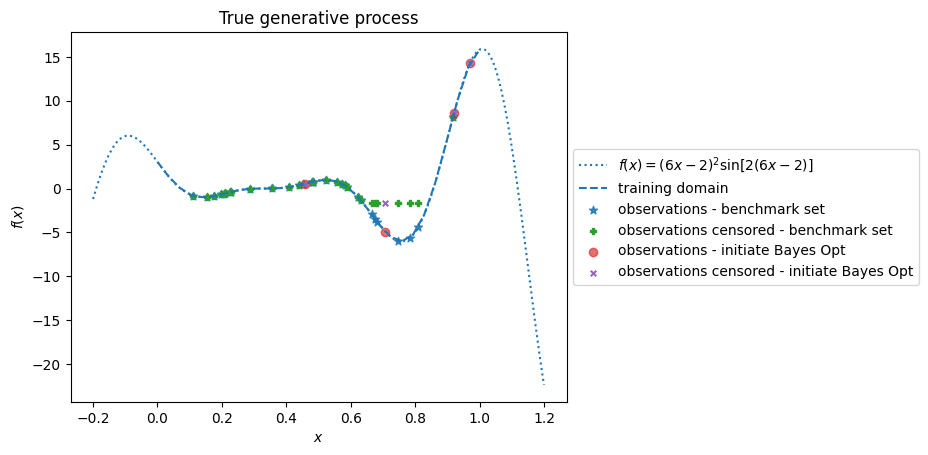

In [11]:
plot_data(noisy=False, benchmark=True, censored=True)

# Experiments

## Code

### Training GPs

In [21]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method


class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.

    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form

    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),

    where :math:`p(y \mid f)` is the likelihood.

    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.

    .. note:: This model can be seen as a special version of
        :class:`.VariationalSparseGP` model with :math:`X_u = X`.

    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """

    def __init__(
        self,
        X,
        y,
        kernel,
        likelihood,
        mean_function=None,
        latent_shape=None,
        noise=None,
        whiten=False,
        jitter=1e-6,
    ):
        assert isinstance(
            X, torch.Tensor
        ), "X needs to be a torch Tensor instead of a {}".format(type(X))
        if y is not None:
            assert isinstance(
                y, torch.Tensor
            ), "y needs to be a torch Tensor instead of a {}".format(type(y))
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

        noise = self.X.new_tensor(1.0) if noise is None else noise
        self.noise = PyroParam(noise, constraints.positive)


    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[:: N + 1] += self.jitter + self.noise # add jitter to the diagonal
        Lff = torch.linalg.cholesky(Kff)

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=identity).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=Lff).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(
            self._pyro_get_fullname("f"),
            dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril).to_event(
                self.f_loc.dim() - 1
            ),
        )

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:

        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).

        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).

        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(
            Xnew,
            self.X,
            self.kernel,
            self.f_loc,
            self.f_scale_tril,
            full_cov=full_cov,
            whiten=self.whiten,
            jitter=self.jitter,
        )
        return loc + self.mean_function(Xnew), cov

    def update_data(self, X, y=None):
        """
        :param torch.Tensor X: A input data for training. Its first dimension is the
            number of data points.
        :param torch.Tensor y: An output data for training. Its last dimension is the
            number of data points.
        """
        if y is not None and X.size(0) != y.size(-1):
            raise ValueError(
                "Expected the number of input data points equal to the "
                "number of output data points, but got {} and {}.".format(
                    X.size(0), y.size(-1)
                )
            )

        y_batch_shape = y.shape[:-1] if y is not None else torch.Size([])
        self.latent_shape = self.latent_shape if self.latent_shape is not None else y_batch_shape

        N = X.size(0)
        f_loc = X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.X = X
        self.y = y


In [46]:
def is_var(gpmodel):
  if type(gpmodel) == pyro.contrib.gp.models.VariationalSparseGP or type(gpmodel) == pyro.contrib.gp.models.VariationalGP or type(gpmodel) == VariationalGP:
    res = True
  else:
    res = False
  return res

def torch_backward(x, retain_graph=None):
    """
    Like ``x.backward()`` for a :class:`~torch.Tensor`, but also accepts
    numbers and tensors without grad_fn (resulting in a no-op)
    """
    if torch.is_tensor(x) and x.grad_fn:
        x.backward(retain_graph=retain_graph)

def optimise(gpmodel, num_steps = 2000, lr_=0.005, MeanFieldElbo=False, clear_param=True, retain_graph=None):
  if clear_param==True:
    pyro.clear_param_store()
  # TODO: redesign this code to suppport different loss functions and optimisers
  optimizer = torch.optim.Adam(gpmodel.parameters(), lr=lr_)
  if MeanFieldElbo==True:
      loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
  else:
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  # optimisation step
  def closure():
      optimizer.zero_grad()
      loss = loss_fn(gpmodel.model, gpmodel.guide)
      torch_backward(loss, retain_graph)
      return loss

  # TODO: add flag to monitor the performance on train and validation set
  # TODO: rewrite the code such that it supports different kernels than RBF hyperparameters
  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      # store outputs from the optimisation
      variances.append(gpmodel.kernel.variance.item())
      lengthscales.append(gpmodel.kernel.lengthscale.item())
      if is_var(gpmodel)==True:
        noises.append(gpmodel.likelihood.variance.item())
      else:
        noises.append(gpmodel.noise.item())
      loss = optimizer.step(closure)
      losses.append(loss.item())

  # prints learnt parameters of the kernel
  gpmodel.set_mode("guide")
  print("\nvariance = {: .6f}".format(gpmodel.kernel.variance))
  print("lengthscale = {: .6f}".format(gpmodel.kernel.lengthscale))
  try:
    if is_var(gpmodel)==True:
      print("noise = {: .6f}".format(gpmodel.likelihood.variance))
    else:
      print("noise = {: .6f}".format(gpmodel.noise))
  except:
    pass
  res = {'model': gpmodel,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [35]:
def visualise_training(kwargs):
  temp = kwargs.copy()
  if 'model' in temp.keys():
    model_ =  temp.pop('model')
  n = len(temp)
  fig, ax = plt.subplots(1, n, figsize=(4*n, 3))
  for idx, (key, val) in enumerate(temp.items()):
      ax[idx].plot(val)
      ax[idx].set_title('{}: {: .4f}'.format(key, val[-1]))


def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, censored=None, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(np.squeeze(X)), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
  plt.scatter(grid, labels, label="training observations")
  plt.plot(X_test, mean.numpy(), label="mean prediction")
  if censored is not None:
    plt.scatter(grid, censored, label="censored observations", s=16, alpha=0.85, color=sns.color_palette()[2], marker='x')
  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

def  is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

def visualise_trajectories(gpmodel, fcn_key_, samples):
  num_test_grid = fcn_dict[fcn_key_][1][3]
  noise = (gpmodel.likelihood.variance if is_var(gpmodel) else gpmodel.noise)
  cov = gpmodel.kernel.forward(torch.Tensor(X_test)) + noise.expand(num_test_grid).diag()
  samples = dist.MultivariateNormal(
              torch.zeros(num_test_grid), covariance_matrix=cov).sample(sample_shape=(samples,))
  fig, ax = plt.subplots(figsize=(8, 3))
  _ = ax.plot(X_test, samples.T, lw=2, alpha=0.4)
  _ = plt.title('variance: {: .4f}, lengthscale: {: .4f}'.format(gpmodel.kernel.variance.item(), gpmodel.kernel.lengthscale.item()))

In [36]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all
from pyro.distributions.torch_distribution import TorchDistributionMixin

__all__ = ["CensoredNormal"]


class CensoredNormal(ExponentialFamily):
    r"""
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensorNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
      # adjust the moments such that it fits the censored normal
        return self.loc

    @property
    def stddev(self):
        return self.scale

    @property
    def variance(self):
        return self.stddev.pow(2)

    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.lower = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    # @constraints.dependent_property(is_discrete=False, event_dim=0)
    # def support(self):
    #     return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        # compute the variance
        var = self.scale**2
        log_scale = (
            math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
        )
        log_probs = (
            -((value - self.loc) ** 2) / (2 * var)
            - log_scale
            - math.log(math.sqrt(2 * math.pi))
         )

        lower_censored_idx = (value <= self.low)
        upper_censored_idx = (value >= self.high)
        lower_cdf_mass = math.log(self._normal_cdf(self.low) + 1e-6) if isinstance(self._normal_cdf(self.low) + 1e-16,
                                                                                                Number) else (self._normal_cdf(self.low) + 1e-6).log()
        upper_cdf_mass = math.log(1 - self._normal_cdf(self.high) + 1e-6) if isinstance(1 - self._normal_cdf(self.high) + 1e-16,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + 1e-6).log()

        lower_cdf_mass = math.log(self._normal_cdf(self.low) + 1e-6) if isinstance(self._normal_cdf(self.low) + 1e-16,
                                                                                                Number) else (self._normal_cdf(self.low) + 1e-6).log()
        upper_cdf_mass = math.log(1 - self._normal_cdf(self.high) + 1e-6) if isinstance(1 - self._normal_cdf(self.high) + 1e-16,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + 1e-6).log()
        log_probs = torch.where(value <= self.low, lower_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_cdf_mass, log_probs)
        return log_probs

    def _normal_cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)

    def _normal_entropy(self):
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)


class PyroCensoredNormal(CensoredNormal, TorchDistributionMixin):
    def __init__(self, loc, scale, low, high, validate_args=None):
        self._unbroadcasted_loc = loc
        self._unbroadcasted_scale = scale
        self._unbroadcasted_low = low
        self._unbroadcasted_high = high
        super().__init__(loc, scale, low, high, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        new = super().expand(batch_shape, _instance=new)
        new._unbroadcasted_loc = self._unbroadcasted_loc
        new._unbroadcasted_scale = self._unbroadcasted_scale
        new._unbroadcasted_low = self._unbroadcasted_low
        new._unbroadcasted_high = self._unbroadcasted_high
        return new

    # @constraints.dependent_property(is_discrete=False, event_dim=0)
    # def support(self):
    #     return constraints.interval(self._unbroadcasted_low, self._unbroadcasted_high)

In [37]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood
from pyro.nn.module import PyroParam, pyro_method

class Gaussian(Likelihood):
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        y_dist = dist.Normal(f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, self.variance.sqrt())
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)

class CensoredHomoscedGaussian(Likelihood):

    def __init__(self, variance=None, low=None, high=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
        self.low = low
        self.high = high

    def forward(self, f_loc, f_var, y=None):
        y_dist = PyroCensoredNormal(loc=f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, scale=self.variance.sqrt(), low=self.low, high=self.high)
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample("y", y_dist, obs=y)



### Bayesian Optimisation

In [26]:
def bayes_optimiser(gpmodel, fcn_key_, steps, update_posterior_steps=1000, kappa_=1.96):
  """
  1. Takes the gpmodel and optimise it for the initial set of points
  2. For step in steps repeat:
    - select the new candidate point to be evaluated by evaluating the acquisition function
    -
  """
  #----- helper functions --------
  def update_posterior(x_new):
      y = fcn_dict[fcn_key_][2](torch.Tensor(x_new)) # evaluate f at new point.
      X = torch.cat([gpmodel.X, torch.Tensor(x_new)]) # incorporate new evaluation
      y = torch.cat([gpmodel.y, y])
      if type(gpmodel) == VariationalGP:
        gpmodel.update_data(X, y)
      else:
        gpmodel.set_data(X, y)
      # optimize the GP hyperparameters using Adam with lr=0.001
      optimise(gpmodel, num_steps=update_posterior_steps, clear_param=False)

  # acquisition function
  def lower_confidence_bound(x, kappa=kappa_):
      mean, cov = gpmodel.forward(torch.Tensor(x), full_cov=True, noiseless=False) if is_var(gpmodel)==False else  gpmodel.forward(torch.Tensor(x), full_cov=True)
      sd = cov.diag().sqrt()
      return mean - kappa * sd

  def find_a_candidate(x_init, lower_bound, upper_bound):
      # transform x to an unconstrained domain
      constraint = constraints.interval(lower_bound, upper_bound)
      unconstrained_x_init = transform_to(constraint).inv(x_init)
      unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
      minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

      def closure():
          minimizer.zero_grad()
          x = transform_to(constraint)(unconstrained_x)
          y = lower_confidence_bound(x)
          autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
          return y

      minimizer.step(closure)
      # after finding a candidate in the unconstrained domain,
      # convert it back to original domain.
      x = transform_to(constraint)(unconstrained_x)
      return x.detach()

  def next_x(lower_bound, upper_bound, num_candidates=5):
      candidates = []
      values = []

      x_init = gpmodel.X[-1:]
      for i in range(num_candidates):
          x = find_a_candidate(x_init, lower_bound, upper_bound)
          # evaluate using acquisiton function
          y = lower_confidence_bound(x)
          candidates.append(x)
          values.append(y)
          x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

      argmin = torch.min(torch.cat(values), dim=0)[1].item()
      return candidates[argmin]

  # ------- main body -----
  # main initialisation
  eps = 1e-04
  lower_bound_ = fcn_dict[fcn_key_][1][0]
  upper_bound_ = fcn_dict[fcn_key_][1][1]
  gpr_res = optimise(gpmodel)
  pbar = tqdm.tqdm(range(steps), position=0, leave=True)

  xmin = []
  variance = []
  lenghtscale = []
  variance.append(gpmodel.kernel.variance.item())
  lenghtscale.append(gpmodel.kernel.lengthscale.item())

  print("--- Starting optimisation: ----")
  for epoch in pbar:
    xmin_ = next_x(lower_bound=lower_bound_, upper_bound=upper_bound_)
    print('Selected xmin: {}'.format(xmin_.item()))
    if xmin_ in gpmodel.X:
      xmin_ = xmin_ + eps
    xmin.append(xmin_.item())

    update_posterior(xmin_)
    variance.append(gpmodel.kernel.variance.item())
    lenghtscale.append(gpmodel.kernel.lengthscale.item())

  res = {'model': gpmodel,
         'x_seq': xmin,
         'variance': variance,
         'lengthscale': lenghtscale
  }
  return res


In [27]:
# pyro.clear_param_store()

# print(gpr.kernel.variance.item(), gpr.kernel.lengthscale.item())
# gpr_res = optimise(gpr)

# for i in range(8):
#     print('------- iter: %s --------'%i)
#     xmin = next_x()
#     print(xmin)
#     print(gpr.kernel.variance.item(), gpr.kernel.lengthscale.item())
#     try:
#       plt.figure()
#       visualise_trajectories(gpr, fcn_key_, 3)
#       plt.show()
#     except:
#       pass
#     plt.figure()
#     visualise_results(gpr)
#     plt.show()
#     update_posterior(xmin)

## 1. GPRegression

This section uses the `gp.models.GPRegression` object on the on the non-censored and censored data to provide the intuition into the impact of the censoring on the Bayesian optimisation.

We have chosen:
  * the radial kernel
  * lower confidence bound acquisition function

### Non-censored data
The benchmark values for the GP if the data were observed fully.

#### Benchmark

In [70]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_benchmark = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_benchmark = gp.models.GPRegression(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark), kernel_benchmark)

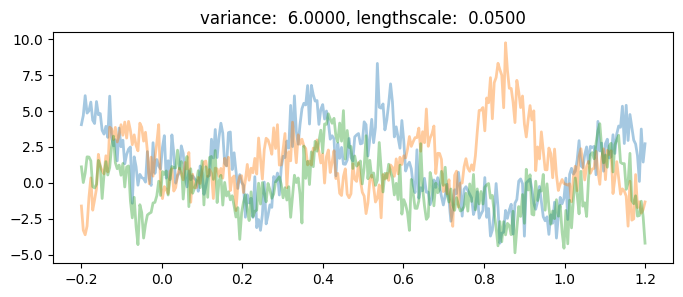

In [71]:
visualise_trajectories(gpr_benchmark, fcn_key_, 3)

In [72]:
gpr_benchmark_res = optimise(gpr_benchmark)

100%|██████████| 2000/2000 [00:11<00:00, 167.56it/s]


variance =  143.236076
lengthscale =  0.192048
noise =  0.000044


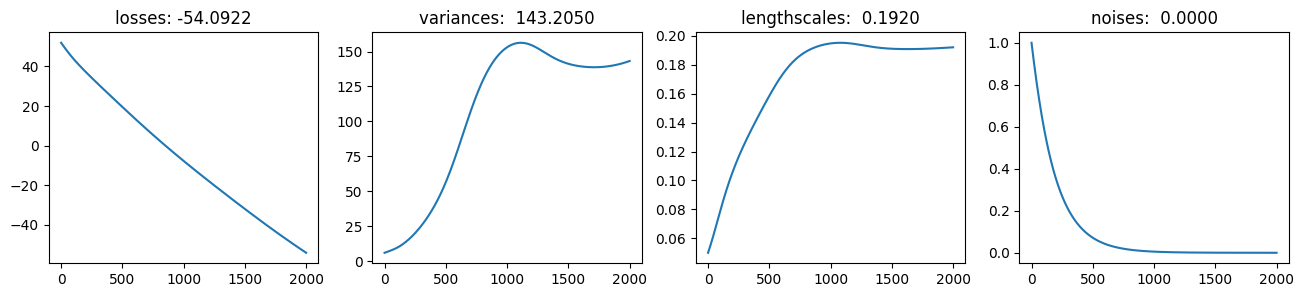

In [73]:
visualise_training(gpr_benchmark_res)

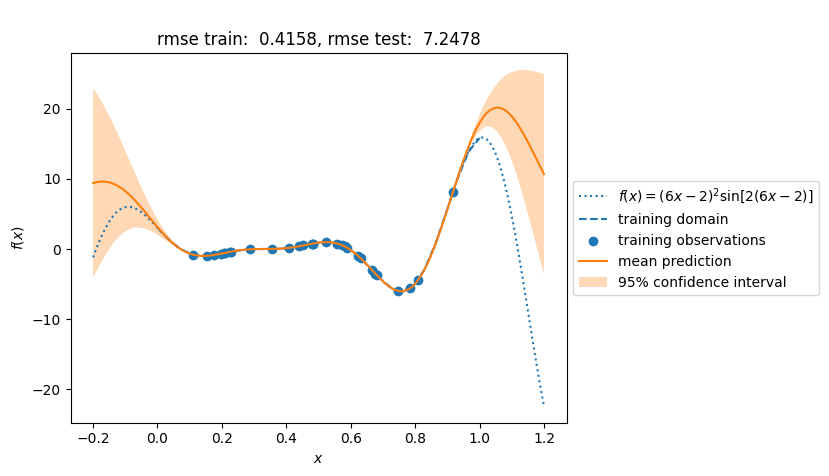

In [74]:
visualise_results(gpr_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark)

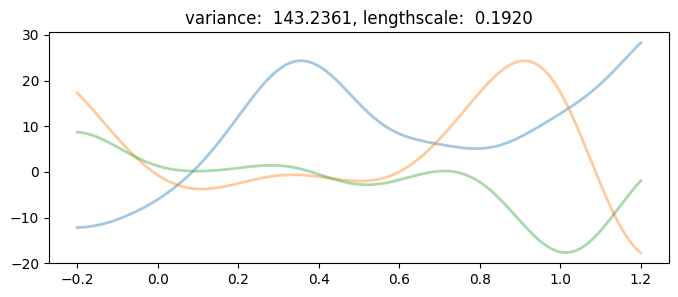

In [75]:
visualise_trajectories(gpr_benchmark, fcn_key_, 3)

#### Bayes Optimisation

In [76]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel)

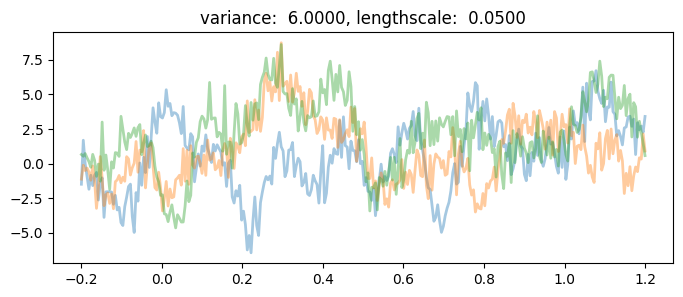

In [77]:
visualise_trajectories(gpr, fcn_key_, 3)

In [78]:
steps_ = N_benchmark - N
print(steps_)
bayes_res = bayes_optimiser(gpr, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:11<00:00, 180.23it/s]



variance =  55.042846
lengthscale =  0.097376
noise =  6.174800


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 0.6057058442585789


  4%|▍         | 1/26 [00:05<02:19,  5.57s/it]


variance =  109.370755
lengthscale =  0.165844
noise =  0.154055
Selected xmin: 0.7592588950329147


  8%|▊         | 2/26 [00:12<02:26,  6.09s/it]


variance =  94.010794
lengthscale =  0.158373
noise =  0.010257
Selected xmin: 1.8194722209358705e-05


 12%|█▏        | 3/26 [00:17<02:13,  5.80s/it]


variance =  75.268883
lengthscale =  0.153783
noise =  0.000808
Selected xmin: 0.21997482146574557


 15%|█▌        | 4/26 [00:23<02:11,  5.96s/it]


variance =  65.045668
lengthscale =  0.152605
noise =  0.000065
Selected xmin: 0.317720545647023


 19%|█▉        | 5/26 [00:29<02:04,  5.93s/it]


variance =  67.993439
lengthscale =  0.160752
noise =  0.000005
Selected xmin: 0.7548657936389114


 23%|██▎       | 6/26 [00:35<02:01,  6.05s/it]


variance =  67.907351
lengthscale =  0.160746
noise =  0.000012
Selected xmin: 0.7562926226191115


 27%|██▋       | 7/26 [00:41<01:51,  5.85s/it]


variance =  61.019022
lengthscale =  0.153396
noise =  0.000000
Selected xmin: 0.7572384433846129


 31%|███       | 8/26 [00:47<01:47,  5.99s/it]


variance =  60.836135
lengthscale =  0.153189
noise =  0.000000
Selected xmin: 0.7572648294326085


 35%|███▍      | 9/26 [00:53<01:38,  5.82s/it]


variance =  60.822613
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7572544310161193


 38%|███▊      | 10/26 [00:59<01:34,  5.92s/it]


variance =  60.821450
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572424837114874


 42%|████▏     | 11/26 [01:04<01:26,  5.77s/it]


variance =  60.821428
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572328447720664


 46%|████▌     | 12/26 [01:10<01:22,  5.91s/it]


variance =  60.821543
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572251154004443


 50%|█████     | 13/26 [01:16<01:15,  5.79s/it]


variance =  60.821682
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572187945779649


 54%|█████▍    | 14/26 [01:22<01:10,  5.85s/it]


variance =  60.821826
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572141490327068


 58%|█████▊    | 15/26 [01:28<01:03,  5.81s/it]


variance =  60.821964
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572088480248201


 62%|██████▏   | 16/26 [01:33<00:58,  5.85s/it]


variance =  60.822090
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572054468148381


 65%|██████▌   | 17/26 [01:39<00:52,  5.88s/it]


variance =  60.822206
lengthscale =  0.153172
noise =  0.000000
Selected xmin: 0.7572013900722663


 69%|██████▉   | 18/26 [01:45<00:46,  5.86s/it]


variance =  60.822313
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571983301465212


 73%|███████▎  | 19/26 [01:51<00:41,  5.94s/it]


variance =  60.822401
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571963044413658


 77%|███████▋  | 20/26 [01:57<00:34,  5.80s/it]


variance =  60.822488
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571930195726538


 81%|████████  | 21/26 [02:03<00:29,  5.91s/it]


variance =  60.822565
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571907633000141


 85%|████████▍ | 22/26 [02:08<00:23,  5.78s/it]


variance =  60.822629
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571887404186313


 88%|████████▊ | 23/26 [02:15<00:17,  5.97s/it]


variance =  60.822686
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571867490058605


 92%|█████████▏| 24/26 [02:20<00:11,  5.80s/it]


variance =  60.822737
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.757185185616401


 96%|█████████▌| 25/26 [02:27<00:05,  5.93s/it]


variance =  60.822779
lengthscale =  0.153173
noise =  0.000000
Selected xmin: 0.7571836346159546


100%|██████████| 26/26 [02:32<00:00,  5.86s/it]


variance =  60.822820
lengthscale =  0.153173
noise =  0.000000


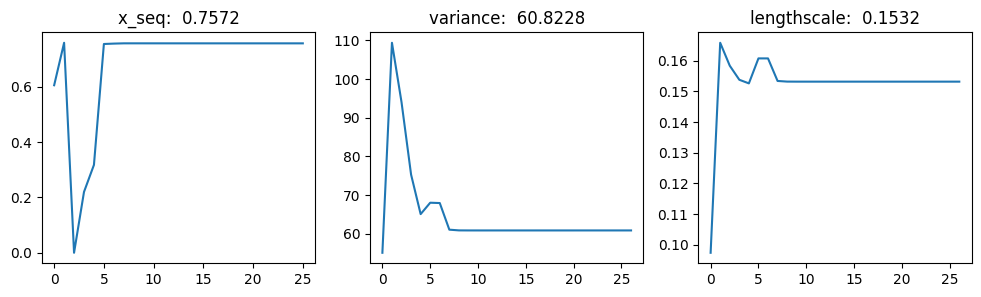

In [79]:
visualise_training(bayes_res)

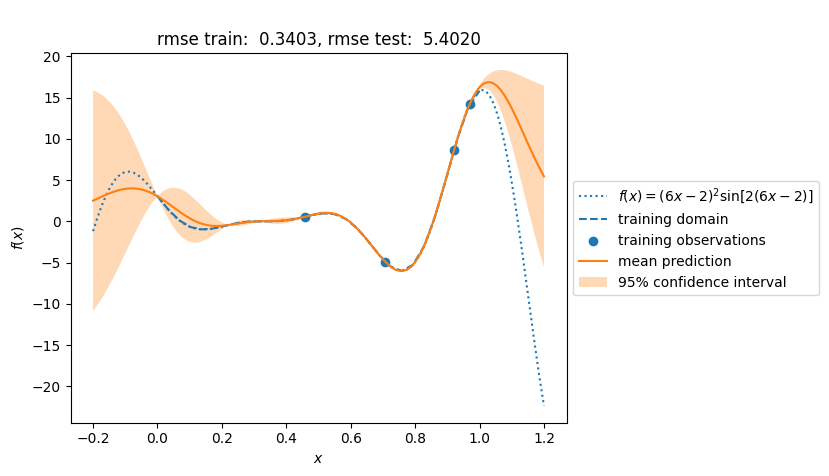

In [80]:
visualise_results(bayes_res['model'])

### Censored data

Applying "wrong modelling approach" to the censored data, i.e. neglecting the censoring.

#### Benchmark

In [81]:
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_benchmark_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_benchmark_censored = gp.models.GPRegression(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark_censored), kernel_benchmark_censored)

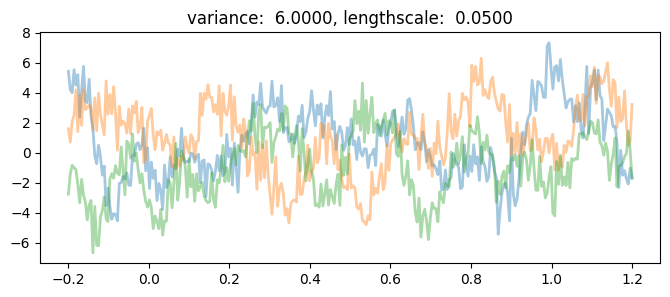

In [82]:
visualise_trajectories(gpr_benchmark_censored, fcn_key_, 3)

In [83]:
gpr_benchmark_censored_res = optimise(gpr_benchmark_censored)

100%|██████████| 2000/2000 [00:11<00:00, 178.71it/s]


variance =  21.333120
lengthscale =  0.100405
noise =  0.005249


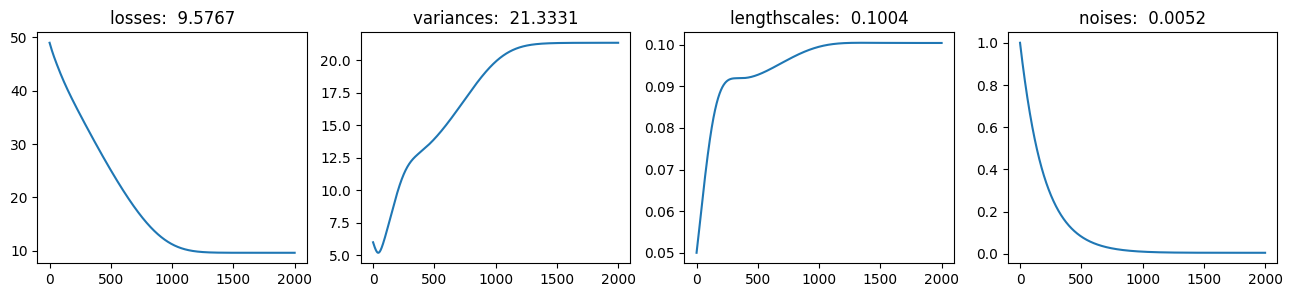

In [84]:
visualise_training(gpr_benchmark_censored_res)

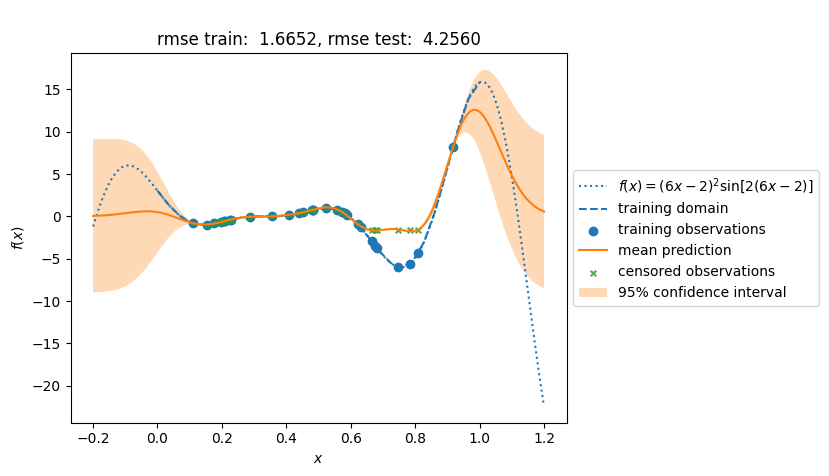

In [85]:
visualise_results(gpr_benchmark_censored_res['model'], grid=X_train_benchmark, labels=y_train_benchmark, censored=y_train_benchmark_censored)

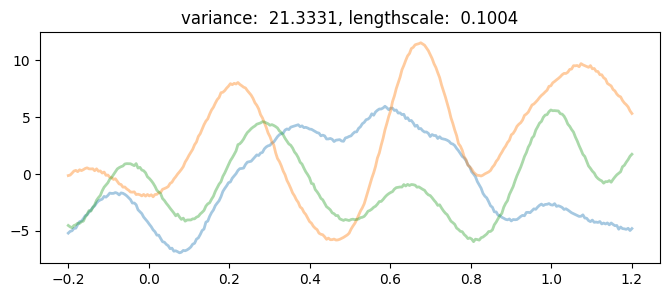

In [86]:
visualise_trajectories(gpr_benchmark_censored, fcn_key_, 3)

#### Bayesian Optimisation

In [87]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_censored = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_censored)

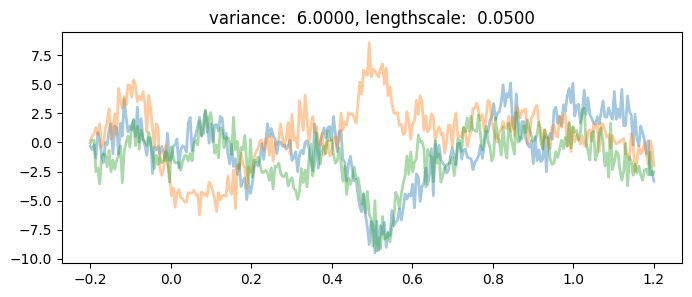

In [88]:
visualise_trajectories(gpr_censored, fcn_key_, 3)

In [89]:
steps_ = N_benchmark - N
print(steps_)
bayes_censored_res = bayes_optimiser(gpr_censored, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:10<00:00, 194.95it/s]



variance =  48.063906
lengthscale =  0.119732
noise =  8.043647


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 2.0995576137402947e-05


  4%|▍         | 1/26 [00:05<02:28,  5.92s/it]


variance =  38.799287
lengthscale =  0.089785
noise =  6.092738
Selected xmin: 0.24848548301731327


  8%|▊         | 2/26 [00:11<02:11,  5.49s/it]


variance =  31.421790
lengthscale =  0.084824
noise =  5.467881
Selected xmin: 0.5951333444105702


 12%|█▏        | 3/26 [00:17<02:14,  5.83s/it]


variance =  38.065821
lengthscale =  0.169560
noise =  4.052383
Selected xmin: 0.6790633940544724


 15%|█▌        | 4/26 [00:22<02:04,  5.65s/it]


variance =  40.683861
lengthscale =  0.162871
noise =  3.241320
Selected xmin: 0.701812520088391


 19%|█▉        | 5/26 [00:29<02:04,  5.93s/it]


variance =  39.529205
lengthscale =  0.146349
noise =  3.118407
Selected xmin: 0.726701044154571


 23%|██▎       | 6/26 [00:34<01:56,  5.82s/it]


variance =  38.816181
lengthscale =  0.128982
noise =  2.960912
Selected xmin: 0.7543358612510092


 27%|██▋       | 7/26 [00:41<01:57,  6.18s/it]


variance =  39.895305
lengthscale =  0.117292
noise =  2.411759
Selected xmin: 0.7708134850701132


 31%|███       | 8/26 [00:47<01:49,  6.07s/it]


variance =  41.552278
lengthscale =  0.115374
noise =  1.877829
Selected xmin: 0.7718575656539636


 35%|███▍      | 9/26 [00:53<01:44,  6.14s/it]


variance =  42.870620
lengthscale =  0.116083
noise =  1.531479
Selected xmin: 0.7710227096335814


 38%|███▊      | 10/26 [00:59<01:36,  6.01s/it]


variance =  43.872709
lengthscale =  0.116999
noise =  1.292719
Selected xmin: 0.7705290426825789


 42%|████▏     | 11/26 [01:05<01:30,  6.03s/it]


variance =  44.648570
lengthscale =  0.117814
noise =  1.118125
Selected xmin: 0.770288567891181


 46%|████▌     | 12/26 [01:11<01:23,  5.96s/it]


variance =  45.258055
lengthscale =  0.118492
noise =  0.984876
Selected xmin: 0.7701894625426523


 50%|█████     | 13/26 [01:18<01:20,  6.19s/it]


variance =  45.741384
lengthscale =  0.119045
noise =  0.879838
Selected xmin: 0.7701705762293698


 54%|█████▍    | 14/26 [01:23<01:12,  6.06s/it]


variance =  46.126633
lengthscale =  0.119492
noise =  0.794912
Selected xmin: 0.7701989092684886


 58%|█████▊    | 15/26 [01:30<01:07,  6.17s/it]


variance =  46.434011
lengthscale =  0.119848
noise =  0.724829
Selected xmin: 0.7702562402069175


 62%|██████▏   | 16/26 [01:35<01:00,  6.02s/it]


variance =  46.678443
lengthscale =  0.120128
noise =  0.666013
Selected xmin: 0.7703321084232949


 65%|██████▌   | 17/26 [01:42<00:55,  6.15s/it]


variance =  46.871186
lengthscale =  0.120344
noise =  0.615951
Selected xmin: 0.770420312744917


 69%|██████▉   | 18/26 [01:48<00:48,  6.00s/it]


variance =  47.020891
lengthscale =  0.120505
noise =  0.572826
Selected xmin: 0.7705170871537161


 73%|███████▎  | 19/26 [01:54<00:42,  6.12s/it]


variance =  47.134317
lengthscale =  0.120618
noise =  0.535291
Selected xmin: 0.7706201055321011


 77%|███████▋  | 20/26 [02:00<00:35,  5.98s/it]


variance =  47.216833
lengthscale =  0.120689
noise =  0.502326
Selected xmin: 0.7707279166333133


 81%|████████  | 21/26 [02:06<00:30,  6.03s/it]


variance =  47.272765
lengthscale =  0.120723
noise =  0.473145
Selected xmin: 0.7708396110213992


 85%|████████▍ | 22/26 [02:11<00:23,  5.92s/it]


variance =  47.305656
lengthscale =  0.120723
noise =  0.447133
Selected xmin: 0.7709546174678389


 88%|████████▊ | 23/26 [02:18<00:18,  6.02s/it]


variance =  47.318453
lengthscale =  0.120694
noise =  0.423800
Selected xmin: 0.7710725536636018


 92%|█████████▏| 24/26 [02:23<00:11,  5.95s/it]


variance =  47.313651
lengthscale =  0.120639
noise =  0.402755
Selected xmin: 0.7711932184923384


 96%|█████████▌| 25/26 [02:30<00:06,  6.01s/it]


variance =  47.293405
lengthscale =  0.120559
noise =  0.383676
Selected xmin: 0.7713164453558454


100%|██████████| 26/26 [02:36<00:00,  6.01s/it]


variance =  47.259616
lengthscale =  0.120457
noise =  0.366301


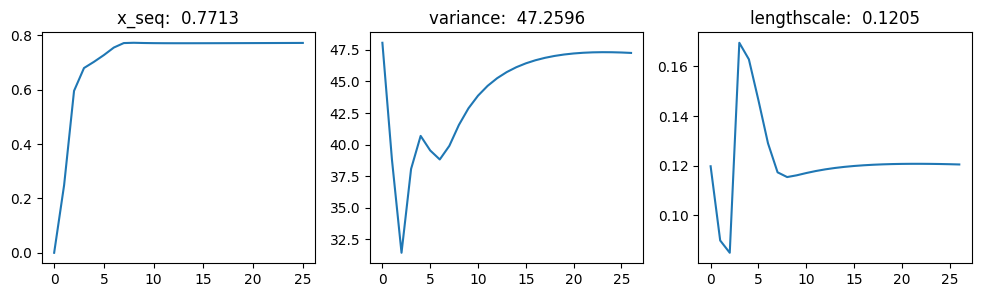

In [90]:
visualise_training(bayes_censored_res)

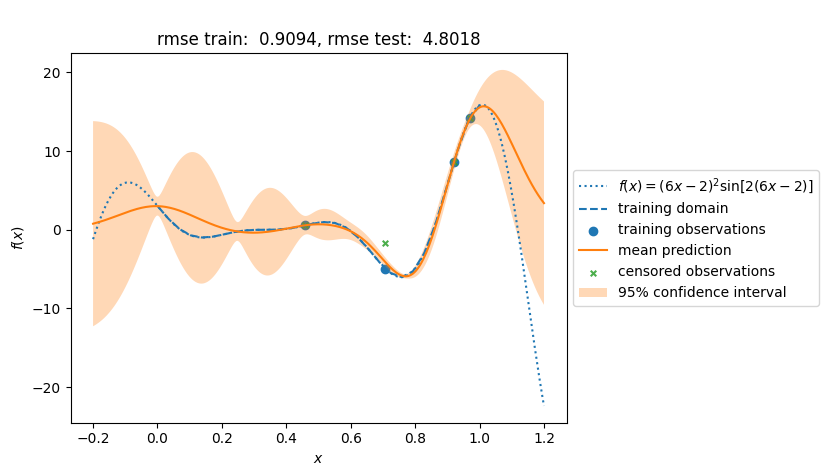

In [91]:
visualise_results(bayes_censored_res['model'], censored=y_train_censored)

## Custom Likelihood

This section uses object `VariationalGP` which supports usage of custom likelihoods.

 * We first check the performance for the Gaussian likelihood to understand the impact of choosing `VariationalGP` object instead of `GPRegressor`.
 * Then we apply explore using Censored Gaussian implementation.

### Non-censored Gaussian

##### Benchmark

In [47]:
likelihood = Gaussian()
likelihood2 = CensoredHomoscedGaussian(low=lower_cf, high=1000.)

In [48]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

In [49]:
kernel_vgp_benchmark = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp_benchmark = VariationalGP(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark),
                                       kernel=kernel_vgp_benchmark, likelihood=likelihood, noise=torch.Tensor([0.]), whiten=True, jitter=1e-06)

In [41]:
#visualise_trajectories(vgp_benchmark, fcn_key_, 3)

In [50]:
vgp_benchmark_res = optimise(vgp_benchmark, 4000)

100%|██████████| 4000/4000 [00:43<00:00, 91.82it/s] 


variance =  6.791722
lengthscale =  0.089690
noise =  0.049775


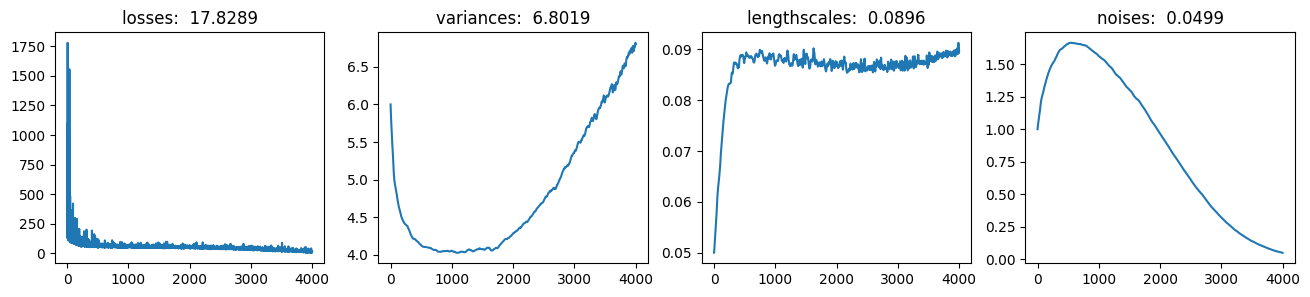

In [51]:
visualise_training(vgp_benchmark_res)

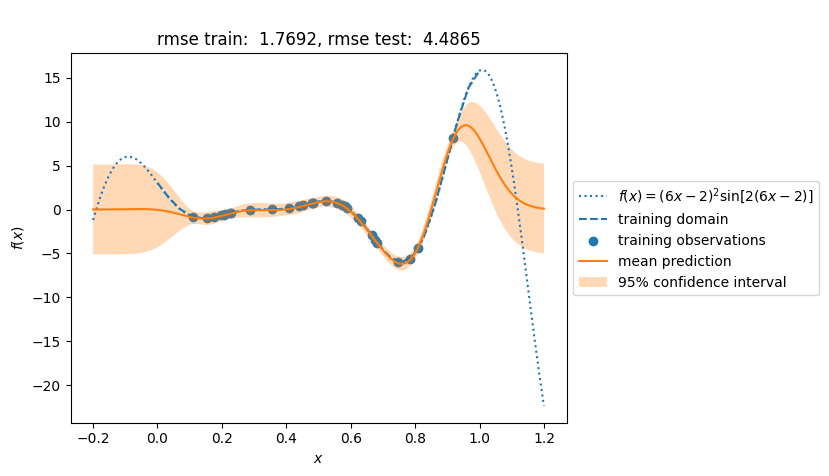

In [52]:
visualise_results(vgp_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark)

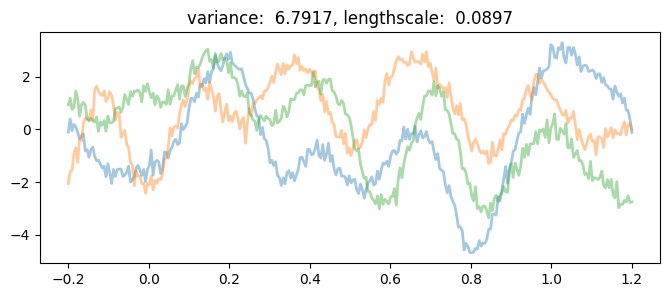

In [53]:
visualise_trajectories(vgp_benchmark_res['model'], fcn_key_, 3)

#### Bayesian Optimisation

In [54]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_vgp1_bayes = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
vgp1_bayes = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train), kernel_vgp1_bayes, likelihood=likelihood, noise=torch.Tensor([0.]), whiten=True, jitter=1e-06)

In [55]:
#visualise_trajectories(vgp1_bayes, fcn_key_, 3)

In [56]:
steps_ = N_benchmark - N
print(steps_)
vgp1_bayes_res = bayes_optimiser(vgp1_bayes, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:19<00:00, 100.60it/s]



variance =  8.756692
lengthscale =  0.116800
noise =  0.450610


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 0.6398406285963983


  4%|▍         | 1/26 [00:10<04:23, 10.55s/it]


variance =  6.594230
lengthscale =  0.086719
noise =  1.996761
Selected xmin: 0.7201438325777362


  8%|▊         | 2/26 [00:20<04:07, 10.32s/it]


variance =  5.359621
lengthscale =  0.078790
noise =  10.341219
Selected xmin: 0.7121054366289605


 12%|█▏        | 3/26 [00:31<03:57, 10.33s/it]


variance =  3.677537
lengthscale =  0.091930
noise =  36.284167
Selected xmin: 0.7608135536818661


 15%|█▌        | 4/26 [00:54<05:40, 15.46s/it]


variance =  1.979929
lengthscale =  0.082741
noise =  42.321367
Selected xmin: 0.7516557425109756


 19%|█▉        | 5/26 [01:06<04:56, 14.14s/it]


variance =  1.823835
lengthscale =  0.083982
noise =  40.544073
Selected xmin: 0.7465642499103462


 23%|██▎       | 6/26 [01:18<04:28, 13.40s/it]


variance =  2.645620
lengthscale =  0.077684
noise =  35.121788
Selected xmin: 0.705431176001126


 27%|██▋       | 7/26 [01:28<03:58, 12.54s/it]


variance =  3.726102
lengthscale =  0.082021
noise =  27.476317
Selected xmin: 0.7312458932759528


 31%|███       | 8/26 [01:39<03:31, 11.77s/it]


variance =  4.931790
lengthscale =  0.080300
noise =  20.967991
Selected xmin: 0.7309418525210463


 35%|███▍      | 9/26 [01:49<03:14, 11.43s/it]


variance =  5.045390
lengthscale =  0.078896
noise =  19.300789
Selected xmin: 0.708921176399809


 38%|███▊      | 10/26 [02:00<02:59, 11.19s/it]


variance =  4.821289
lengthscale =  0.076796
noise =  18.226248
Selected xmin: 0.713248253068759


 42%|████▏     | 11/26 [02:11<02:45, 11.05s/it]


variance =  5.081339
lengthscale =  0.076886
noise =  16.267576
Selected xmin: 0.7108878580338285


 46%|████▌     | 12/26 [02:21<02:33, 10.97s/it]


variance =  5.454606
lengthscale =  0.077189
noise =  13.961095
Selected xmin: 0.7176110355500663


 50%|█████     | 13/26 [02:33<02:25, 11.16s/it]


variance =  6.024132
lengthscale =  0.077130
noise =  12.259794
Selected xmin: 0.7113442495456713


 54%|█████▍    | 14/26 [02:45<02:15, 11.27s/it]


variance =  6.000209
lengthscale =  0.076095
noise =  12.281205
Selected xmin: 0.7158301984394762


 58%|█████▊    | 15/26 [02:59<02:13, 12.14s/it]


variance =  6.192463
lengthscale =  0.073659
noise =  11.224282
Selected xmin: 0.7149523006138403


 62%|██████▏   | 16/26 [03:10<01:57, 11.75s/it]


variance =  5.280823
lengthscale =  0.068420
noise =  13.527782
Selected xmin: 0.7126534622160915


 65%|██████▌   | 17/26 [03:26<01:59, 13.24s/it]


variance =  5.819984
lengthscale =  0.074688
noise =  10.046336
Selected xmin: 0.7174910899796266


 69%|██████▉   | 18/26 [03:39<01:45, 13.23s/it]


variance =  6.338540
lengthscale =  0.071455
noise =  9.754950
Selected xmin: 0.7779752910718654


 73%|███████▎  | 19/26 [03:51<01:28, 12.63s/it]


variance =  6.010534
lengthscale =  0.069930
noise =  10.485614
Selected xmin: 0.7707289551358438


 77%|███████▋  | 20/26 [04:01<01:12, 12.07s/it]


variance =  5.471910
lengthscale =  0.066845
noise =  11.491258
Selected xmin: 0.7244057554599284


 81%|████████  | 21/26 [04:12<00:58, 11.73s/it]


variance =  6.683937
lengthscale =  0.077400
noise =  7.206064
Selected xmin: 0.7218706286488048


 85%|████████▍ | 22/26 [04:23<00:45, 11.49s/it]


variance =  5.439108
lengthscale =  0.056714
noise =  10.938065
Selected xmin: 0.7635165680554953


 88%|████████▊ | 23/26 [04:35<00:34, 11.57s/it]


variance =  5.290865
lengthscale =  0.067440
noise =  9.582210
Selected xmin: 0.7621735459399912


 92%|█████████▏| 24/26 [04:46<00:22, 11.26s/it]


variance =  6.549363
lengthscale =  0.070644
noise =  6.891537
Selected xmin: 0.7653841586713537


 96%|█████████▌| 25/26 [04:58<00:11, 11.56s/it]


variance =  5.766099
lengthscale =  0.055282
noise =  9.528171
Selected xmin: 0.7598909440477449


100%|██████████| 26/26 [05:10<00:00, 11.95s/it]


variance =  6.048443
lengthscale =  0.063556
noise =  8.174273


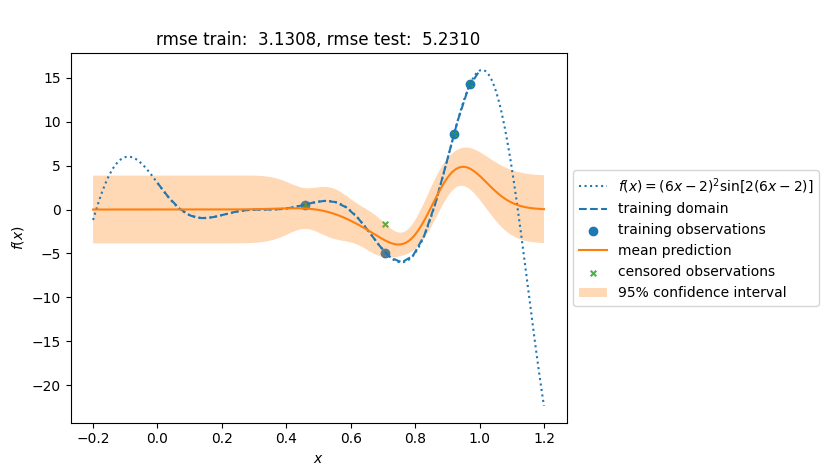

In [62]:
visualise_results(vgp1_bayes_res['model'], censored=y_train_censored)

### Censored Gaussian

* two different implementations of ELBO: `pyro.infer.TraceMeanField_ELBO()` and `pyro.infer.Trace_ELBO()`

##### Benchmark

In [57]:
pyro.clear_param_store()

kernel_vgp2_benchmark = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

vgp2_benchmark = VariationalGP(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark_censored),
                                       kernel=kernel_vgp2_benchmark, likelihood=likelihood2, noise=torch.Tensor([0.]), whiten=True, jitter=1e-06)

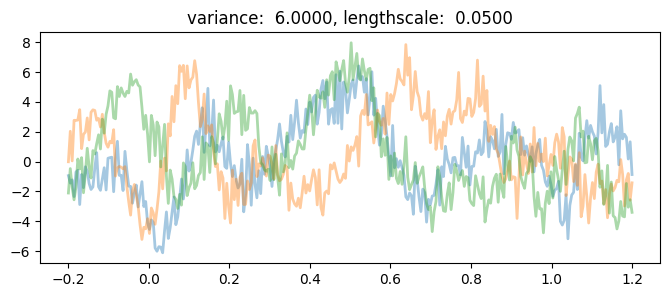

In [58]:
# visualise_trajectories(vgp2_benchmark, fcn_key_, 3)

In [59]:
vgp2_benchmark_res = optimise(vgp2_benchmark)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:303: UserWarning: <class '__main__.PyroCensoredNormal'> does not define `support` to enable sample validation. Please initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
100%|██████████| 2000/2000 [00:25<00:00, 79.39it/s]


variance =  3.889934
lengthscale =  0.085473
noise =  0.735364


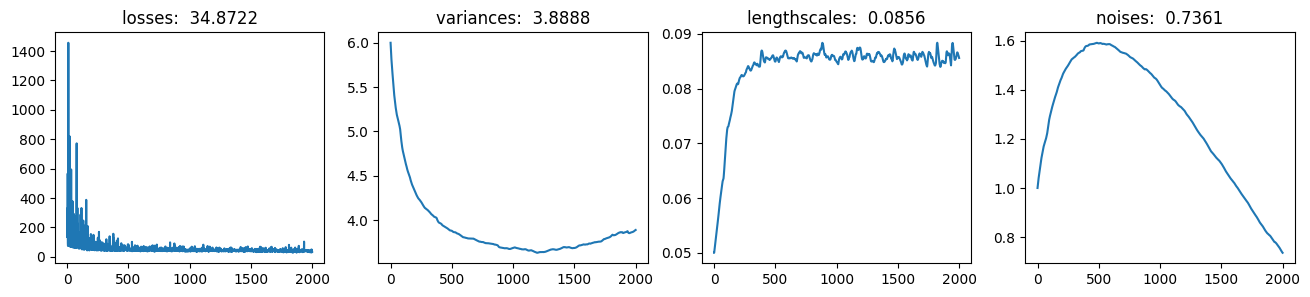

In [63]:
visualise_training(vgp2_benchmark_res)

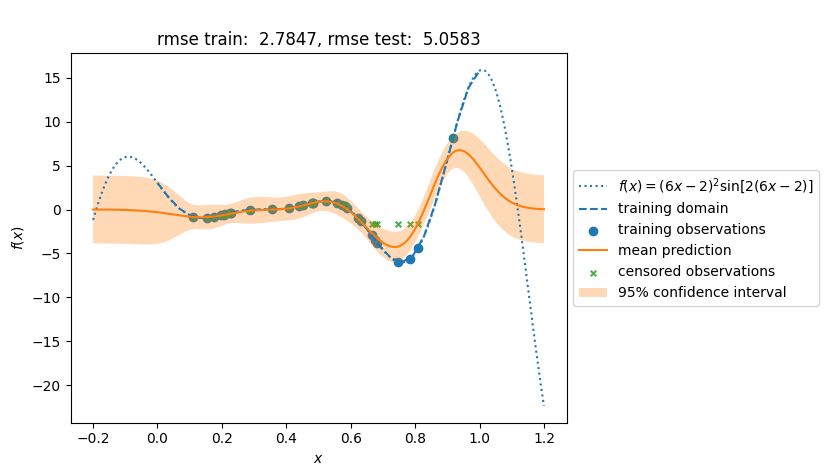

In [64]:
visualise_results(vgp2_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark, censored=y_train_benchmark_censored)

#### Bayesian Optimisation

In [65]:
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_vgp2_bayes = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
vgp2_bayes = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_vgp2_bayes, likelihood=likelihood2, noise=torch.Tensor([0.]), whiten=True, jitter=1e-06)

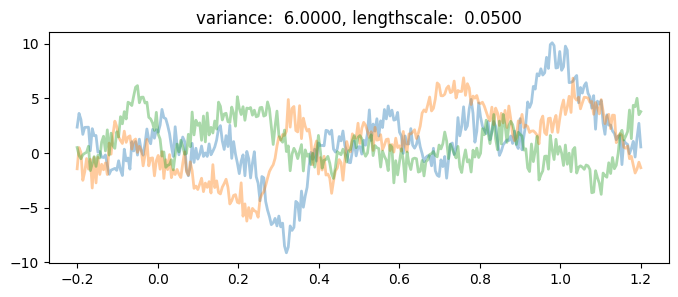

In [66]:
visualise_trajectories(vgp2_bayes, fcn_key_, 3)

In [67]:
steps_ = N_benchmark - N
print(steps_)
vgp2_bayes_res = bayes_optimiser(vgp2_bayes, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:22<00:00, 89.39it/s]



variance =  10.307722
lengthscale =  0.089163
noise =  5.887359


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 0.6206006553510541


  4%|▍         | 1/26 [00:12<05:02, 12.11s/it]


variance =  7.116004
lengthscale =  0.106502
noise =  20.636042
Selected xmin: 0.00021814112589262804


  8%|▊         | 2/26 [00:24<04:56, 12.35s/it]


variance =  3.791851
lengthscale =  0.114500
noise =  49.664019
Selected xmin: 0.24532004246989722


 12%|█▏        | 3/26 [00:36<04:41, 12.25s/it]


variance =  1.408641
lengthscale =  0.097614
noise =  47.305284
Selected xmin: 0.7199815284108918


 15%|█▌        | 4/26 [00:49<04:29, 12.27s/it]


variance =  0.938943
lengthscale =  0.082319
noise =  49.278208
Selected xmin: 0.6935922495708808


 19%|█▉        | 5/26 [01:01<04:17, 12.27s/it]


variance =  0.927533
lengthscale =  0.080126
noise =  51.114684
Selected xmin: 0.7038228583624124


 23%|██▎       | 6/26 [01:13<04:05, 12.29s/it]


variance =  1.314449
lengthscale =  0.076930
noise =  49.957915
Selected xmin: 0.6548987906914034


 27%|██▋       | 7/26 [01:26<03:54, 12.36s/it]


variance =  1.629001
lengthscale =  0.089669
noise =  49.714203
Selected xmin: 0.7061586327637616


 31%|███       | 8/26 [01:38<03:43, 12.39s/it]


variance =  2.040049
lengthscale =  0.087199
noise =  50.153934
Selected xmin: 0.741267862807654


 35%|███▍      | 9/26 [01:50<03:30, 12.37s/it]


variance =  2.535969
lengthscale =  0.089469
noise =  48.127393
Selected xmin: 0.699554475250714


 38%|███▊      | 10/26 [02:03<03:18, 12.38s/it]


variance =  3.441651
lengthscale =  0.092541
noise =  42.840680
Selected xmin: 0.7344502986140059


 42%|████▏     | 11/26 [02:15<03:05, 12.35s/it]


variance =  4.440976
lengthscale =  0.086681
noise =  36.641675
Selected xmin: 0.6975036820021271


 46%|████▌     | 12/26 [02:28<02:54, 12.43s/it]


variance =  4.885871
lengthscale =  0.087142
noise =  34.477419
Selected xmin: 0.7137683581249659


 50%|█████     | 13/26 [02:40<02:41, 12.43s/it]


variance =  5.413674
lengthscale =  0.085825
noise =  32.028668
Selected xmin: 0.7110968685521075


 54%|█████▍    | 14/26 [02:53<02:29, 12.45s/it]


variance =  5.658921
lengthscale =  0.085036
noise =  30.765565
Selected xmin: 0.7177876387613992


 58%|█████▊    | 15/26 [03:05<02:16, 12.44s/it]


variance =  6.093542
lengthscale =  0.082138
noise =  29.548009
Selected xmin: 0.7207683333565886


 62%|██████▏   | 16/26 [03:18<02:05, 12.58s/it]


variance =  6.240007
lengthscale =  0.087319
noise =  29.159109
Selected xmin: 0.7159412850888043


 65%|██████▌   | 17/26 [03:30<01:52, 12.54s/it]


variance =  6.288035
lengthscale =  0.084294
noise =  28.852514
Selected xmin: 0.7156203536115215


 69%|██████▉   | 18/26 [03:43<01:40, 12.53s/it]


variance =  6.844803
lengthscale =  0.081619
noise =  25.497600
Selected xmin: 0.7098649540376386


 73%|███████▎  | 19/26 [03:56<01:28, 12.67s/it]


variance =  7.185127
lengthscale =  0.081017
noise =  25.716719
Selected xmin: 0.7109437644393878


 77%|███████▋  | 20/26 [04:09<01:15, 12.67s/it]


variance =  6.843147
lengthscale =  0.082942
noise =  27.632977
Selected xmin: 0.7134813232577675


 81%|████████  | 21/26 [04:21<01:03, 12.73s/it]


variance =  7.272765
lengthscale =  0.077837
noise =  26.055332
Selected xmin: 0.718502948261595


 85%|████████▍ | 22/26 [04:34<00:51, 12.78s/it]


variance =  7.539509
lengthscale =  0.084561
noise =  24.915483
Selected xmin: 0.718334653319341


 88%|████████▊ | 23/26 [04:47<00:38, 12.76s/it]


variance =  7.810106
lengthscale =  0.079645
noise =  24.240557
Selected xmin: 0.7136699821356945


 92%|█████████▏| 24/26 [05:00<00:25, 12.90s/it]


variance =  7.572144
lengthscale =  0.078072
noise =  25.798065
Selected xmin: 0.7162171788753058


 96%|█████████▌| 25/26 [05:13<00:12, 12.99s/it]


variance =  7.698769
lengthscale =  0.081749
noise =  24.803521
Selected xmin: 0.7096281882351392


100%|██████████| 26/26 [05:27<00:00, 12.61s/it]


variance =  7.537153
lengthscale =  0.075005
noise =  25.175801


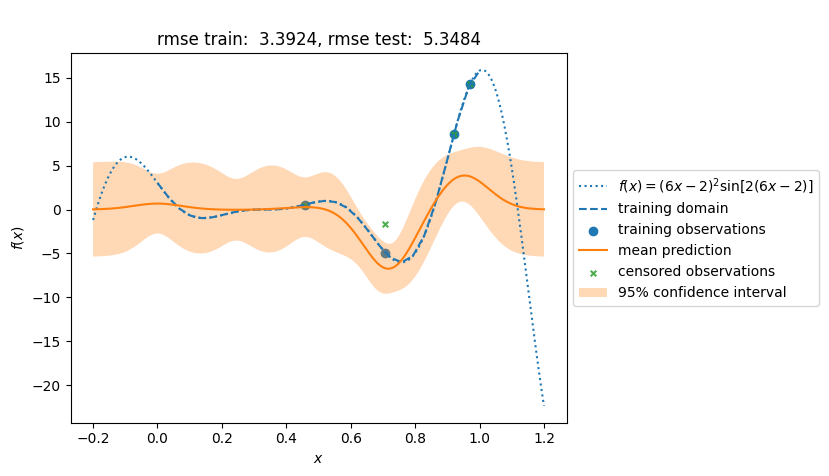

In [69]:
visualise_results(vgp2_bayes_res['model'], censored=y_train_censored)